# Import library

In [134]:
import copy
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import pickle


# Load data

In [135]:
df = pd.read_csv('../data/data.csv')

# Data overview

In [136]:
def describle_data():
    print('Shape of data:\n', df.shape)
    print('--'*20)
    print('Columns of data: \n', df.columns)
    print('--'*20)
    print('Data types of data: \n', df.dtypes)
    print('--'*20)
    print('Missing values of data: \n', df.isna().sum())
    print('--'*20)
    print('Describe data: \n', df.describe())
    print('--'*20)
    print('Info data: \n', df.info())
describle_data()

Shape of data:
 (26956, 11)
----------------------------------------
Columns of data: 
 Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'driven kms',
       'num_of_door', 'num_of_seat', 'engine_type', 'transmission', 'url'],
      dtype='object')
----------------------------------------
Data types of data: 
 car_name           object
year               object
price              object
assemble_place     object
series             object
driven kms        float64
num_of_door       float64
num_of_seat       float64
engine_type        object
transmission       object
url                object
dtype: object
----------------------------------------
Missing values of data: 
 car_name          38
year              11
price             11
assemble_place    11
series            11
driven kms        11
num_of_door       11
num_of_seat       11
engine_type       11
transmission      11
url               11
dtype: int64
----------------------------------------
Describe data: 
     

# Xóa bỏ những xe bị trùng lặp

In [137]:
df.drop_duplicates(subset=['url'], inplace=True)
describle_data()

Shape of data:
 (25157, 11)
----------------------------------------
Columns of data: 
 Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'driven kms',
       'num_of_door', 'num_of_seat', 'engine_type', 'transmission', 'url'],
      dtype='object')
----------------------------------------
Data types of data: 
 car_name           object
year               object
price              object
assemble_place     object
series             object
driven kms        float64
num_of_door       float64
num_of_seat       float64
engine_type        object
transmission       object
url                object
dtype: object
----------------------------------------
Missing values of data: 
 car_name          35
year               1
price              1
assemble_place     1
series             1
driven kms         1
num_of_door        1
num_of_seat        1
engine_type        1
transmission       1
url                1
dtype: int64
----------------------------------------
Describe data: 
     

# Chuyển đổi kiểu dữ liệu cho các cột year, price sang kiểu số thực để có thể thực hiện các phép tính toán

Year

In [138]:
def process_year_colum(year):
    if year.isdigit():
        return float(year)
    else:
        return 0
df['year'] = df['year'].astype(str).apply(process_year_colum)
describle_data()

Shape of data:
 (25157, 11)
----------------------------------------
Columns of data: 
 Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'driven kms',
       'num_of_door', 'num_of_seat', 'engine_type', 'transmission', 'url'],
      dtype='object')
----------------------------------------
Data types of data: 
 car_name           object
year              float64
price              object
assemble_place     object
series             object
driven kms        float64
num_of_door       float64
num_of_seat       float64
engine_type        object
transmission       object
url                object
dtype: object
----------------------------------------
Missing values of data: 
 car_name          35
year               0
price              1
assemble_place     1
series             1
driven kms         1
num_of_door        1
num_of_seat        1
engine_type        1
transmission       1
url                1
dtype: int64
----------------------------------------
Describe data: 
     

Price

In [139]:
df.isna().sum()
df.dropna(subset=['car_name'], inplace=True)

In [140]:
def process_price(price):
    try:
        if price.find('Tỷ') != -1:
            ty= price.split('Tỷ')[0]
            trieu = price.split('Tỷ')[1]
            trieu = trieu.split('Triệu')[0]
            return float(ty)*1000000000 + float(trieu)*1000000
        elif price.find('Triệu') != -1:
            trieu = price.split('Triệu')[0]
            trieu = trieu.replace(' ','')
            return float(trieu)*1000000
        else:
            return 0
    except:
        return 0
df['price'] = df['price'].astype(str).apply(process_price)

In [141]:
df['driven kms'].describe()
# lấy ra các xe có số km đi được nhỏ hơn 1000km
print(df[df['driven kms'] < 1000]['url'])

57       https://bonbanh.com/xe-mercedes_benz-c_class-c...
64       https://bonbanh.com/xe-mercedes_benz-c_class-c...
89       https://bonbanh.com/xe-mercedes_benz-c_class-c...
153      https://bonbanh.com/xe-gaz-khac-sadko-2002-493...
169      https://bonbanh.com/xe-kia-morning-slx-1.0-at-...
                               ...                        
26814    https://bonbanh.com/xe-mazda-3-1.5-at-2015-483...
26829    https://bonbanh.com/xe-toyota-camry-2.5hv-2022...
26889    https://bonbanh.com/xe-mercedes_benz-glc-300-4...
26890    https://bonbanh.com/xe-mercedes_benz-e_class-e...
26894    https://bonbanh.com/xe-toyota-venza-2.7-2009-4...
Name: url, Length: 627, dtype: object


In [142]:
#drop all rows with driven kms < 1000, nan values in all columns
df.drop(df[df['driven kms'] < 1000].index, inplace=True)
df.dropna(inplace=True)
df.isna().sum()

car_name          0
year              0
price             0
assemble_place    0
series            0
driven kms        0
num_of_door       0
num_of_seat       0
engine_type       0
transmission      0
url               0
dtype: int64

In [143]:
df['price'].describe()


count    2.449400e+04
mean     1.059076e+09
std      1.652340e+09
min      0.000000e+00
25%      3.880000e+08
50%      5.600000e+08
75%      9.350000e+08
max      3.860000e+10
Name: price, dtype: float64

# Xử lý các cột dạng nhãn

Car_name có hai phần là hãng xe và tên xe, ta sẽ tách ra thành hai cột là brand và model


In [144]:
df['brand'] = df['car_name'].str.split().str[0]
df['model'] = df['car_name'].str.split().str[1:].str.join(' ')

In [145]:
df['brand'].value_counts()

brand
Toyota        4673
Hyundai       2775
Mercedes      2732
Kia           2628
Ford          2198
              ... 
Haima            1
Scion            1
Dothanh          1
B                1
Brilliance       1
Name: count, Length: 84, dtype: int64

In [146]:
df.head()

,car_name,year,price,assemble_place,series,driven kms,num_of_door,num_of_seat,engine_type,transmission,url,brand,model
0,LandRover Range Rover HSE 3.0,2015.0,2.700000e+09,Nhập khẩu,SUV,65000.0,5.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-landrover-range_rover-h...,LandRover,Range Rover HSE 3.0
1,Mitsubishi Outlander 2.0 CVT Premium,2018.0,6.660000e+08,Lắp ráp trong nước,SUV,50000.0,5.0,7.0,Xăng,Số tự động,https://bonbanh.com/xe-mitsubishi-outlander-2....,Mitsubishi,Outlander 2.0 CVT Premium
2,Mazda 3 1.5L Luxury,2019.0,4.900000e+08,Lắp ráp trong nước,Sedan,51000.0,4.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-mazda-3-1.5l-luxury-201...,Mazda,3 1.5L Luxury
3,Mazda 2 1.5 AT,2015.0,3.650000e+08,Lắp ráp trong nước,Sedan,38000.0,4.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-mazda-2-1.5-at-2015-491...,Mazda,2 1.5 AT
4,Suzuki Swift GLX 1.2 AT,2021.0,5.650000e+08,Nhập khẩu,Hatchback,6000.0,5.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-suzuki-swift-glx-1.2-at...,Suzuki,Swift GLX 1.2 AT


# Xử lý các dữ liệu bị thiếu hoặc sai


Xử lý cột year

In [147]:
car_before_1990 = df[df['year'] < 1990]
print('Number of car before 1990: ', car_before_1990.shape[0])
print('Number of car before 1990: ', car_before_1990['year'].value_counts())

Number of car before 1990:  197
Number of car before 1990:  year
0.0      195
200.0      1
700.0      1
Name: count, dtype: int64


Điền các giá trị sai trong cột year bằng giá trị xuất hiện nhiều nhất trong cột year

In [148]:
df['year'] = df['year'].apply(lambda x: df['year'].value_counts().index[0] if x < 1990 else x)

Cột price: các giá trị bằng = 0 sẽ được thay thế bằng giá trung bình của các xe sản xuất trong năm đó

In [149]:
df['price'] = df['price'].apply(lambda x: df[df['year'] == x]['price'].mean() if x == 0 else x)
df['price'].describe()

count    2.422200e+04
mean     1.070969e+09
std      1.657754e+09
min      1.500000e+07
25%      3.950000e+08
50%      5.650000e+08
75%      9.450000e+08
max      3.860000e+10
Name: price, dtype: float64

Cột num_of_door
Thông thường các xe có tối đa 5 - 6 cửa, với những giá trị sai ta sẽ điền bằng giá trị xuất hiện nhiều nhất trong cột num_of_door

In [150]:
df['num_of_door'] = df['num_of_door'].apply(lambda x: df['num_of_door'].value_counts().index[0] if x > 6 else x)

Cột brand

In [151]:
df['brand'].value_counts()

brand
Toyota        4673
Hyundai       2775
Mercedes      2732
Kia           2628
Ford          2198
              ... 
Haima            1
Scion            1
Dothanh          1
B                1
Brilliance       1
Name: count, Length: 84, dtype: int64

Cột brand có một số hãng có số lượng xe rất ít hoặc bị thiếu, ta sẽ gộp các hãng xe này thành một nhóm là 'other'
Nếu số xe của hãng đó nhỏ hơn 10 thì sẽ gộp vào nhóm 'Other'

In [152]:
threshold = 10
car_count = df['brand'].value_counts()
small_brands = car_count[car_count < threshold].index.tolist()
df['brand'] = df['brand'].apply(lambda x: 'Other' if x in small_brands else x)
df['brand'].fillna('Other', inplace=True)

In [153]:
# in ra tất cả brand
# sắp xếp theo thứ tự giảm dần về giá trung bình
print(df.groupby('brand')['price'].mean().sort_values(ascending=False))




brand
Rolls         1.353504e+10
Bentley       1.051563e+10
Lincoln       6.090806e+09
LandRover     4.225815e+09
Porsche       3.935113e+09
Maserati      3.554455e+09
Lexus         3.269779e+09
Jeep          2.567481e+09
Cadillac      2.515273e+09
Other         2.386693e+09
Volvo         2.218634e+09
Mercedes      1.983761e+09
Infiniti      1.817357e+09
Jaguar        1.798727e+09
Mini          1.427632e+09
BMW           1.419686e+09
Audi          1.260817e+09
Subaru        9.207143e+08
Volkswagen    8.610816e+08
Peugeot       8.171441e+08
Toyota        7.603698e+08
Ford          6.443476e+08
VinFast       5.645952e+08
Mazda         5.533326e+08
Hyundai       5.407181e+08
Honda         5.288325e+08
MG            5.091250e+08
Mitsubishi    5.085244e+08
Kia           4.866314e+08
Nissan        4.486019e+08
Acura         4.450000e+08
Isuzu         4.026667e+08
Suzuki        3.881957e+08
Chevrolet     3.774071e+08
Ssangyong     3.037500e+08
Thaco         2.841250e+08
Dongben       1.425000

In [154]:
# def car_band(x):
#     if x in ['Land', 'Lamborghini', 'Jaguar', 'BMW', 'Mercedes', 'Porsche','Jeep',
#        'Audi', 'Bentley','Mini','LandRover','Lexus','Maserati','Rolls','Ferrari','Aston','Lincoln','Maserati','Cadillac']:
#         return 'HIGH END CAR'    
#     elif x in ['Ford',
#             'Skoda',
#          'Mahindra',
#             'Force',
#        'Mitsubishi',
#            'Toyota',
#             'ISUZU',
#            'Volvo',
#           'Isuzu','Other']:
#         return 'MIDDLE RANGE CAR'
#     else:
#         return 'LOW END CAR'
# df['brand']=df['brand'].apply(car_band)
# def car_band(x):
#     if x in ['Rolls', 'Bentley', 'Ferrari','Lincoln','Porsche','LandRover','Lexus','Jeep']:
#         return 'LUXURY CAR'
#     elif x in ['Maserati', 'Cadillac', 'Lincoln', 'Mercedes', 'Audi', 'BMW', 'Volvo']:
#         return 'PREMIUM CAR'
#     elif x in ['VW', 'Seat', 'Ford', 'Opel','VinFast','Mazda','Honda','Hyundai','Kia','Chevrolet','Toyota','Suzuki','Nissan','Renault','Other']:
#         return 'VOLUME CAR'
#     else:
#         return 'LOW-PRICE CAR'
# def car_band(x):
#     if x in ['Rolls-Royce', 'Bentley', 'Lincoln', 'Land Rover', 'Porsche', 'Maserati', 'Lexus', 'Jeep', 'Cadillac']:
#         return 'LUXURY CAR'
#     elif x in ['Mini', 'BMW', 'Audi', 'Volvo', 'Mercedes-Benz', 'Infiniti', 'Jaguar','Other']:
#         return 'PREMIUM CAR'
#     elif x in ['Subaru', 'Volkswagen', 'Peugeot', 'Toyota', 'Ford', 'VinFast', 'Mazda', 'Hyundai', 'Honda']:
#         return 'VOLUME CAR'
#     else:
#         return 'LOW-PRICE CAR'
def car_band(x):
    if x in ['Rolls', 'Bentley', 'Lincoln', 'LandRover', 'Porsche', 'Maserati', 'Lexus', 'Jeep', 'Cadillac']:
        return 'LUXURY'
    elif x in ['Other', 'Volvo', 'Mercedes', 'Infiniti', 'Jaguar', 'Mini', 'BMW', 'Audi']:
        return 'PREMIUM'
    elif x in ['Subaru', 'Volkswagen', 'Peugeot', 'Toyota', 'Ford', 'VinFast', 'Mazda', 'Hyundai', 'Honda','MG','Mitsubishi']:
        return 'VOLUME'
    else:
        return 'LOWEND'

df['brand_segment'] = df['brand'].apply(car_band)
df.drop(columns=['brand'], inplace=True)
df['brand_segment'].value_counts()


brand_segment
VOLUME     14526
LOWEND      4215
PREMIUM     3751
LUXURY      2002
Name: count, dtype: int64

Cột series: ta thấy các giá trị của cột series có giá trị nan, ta sẽ điền các giá trị này bằng giá trị xuất hiện nhiều nhất trong cột series

In [155]:
df['series'] = df['series'].apply(lambda x: df['series'].value_counts().index[0] if x == '-' else x)
df['series'].fillna(df['series'].value_counts().index[0], inplace=True)

In [156]:
df['series'].isna().sum()

0

Cột engine_type: ta thấy có một vài giá trị bị thiếu, ta sẽ điền các giá trị này bằng giá trị xuất hiện nhiều nhất trong cột engine_type

In [157]:
df['engine_type'] = df['engine_type'].apply(lambda x: df['engine_type'].value_counts().index[0] if x == '-' else x)
df['engine_type'].fillna(df['engine_type'].value_counts().index[0], inplace=True)

In [158]:
df['engine_type'].isna().sum()

0

Cột transmission tương tự cột engine_type

In [159]:
df['transmission'] = df['transmission'].apply(lambda x: df['transmission'].value_counts().index[0] if x == '-' else x)
df['transmission'].fillna(df['transmission'].value_counts().index[0], inplace=True)

In [160]:
df['transmission'].isna().sum()

0

# Trực quan hóa dữ liệu

Tìm hiểu về mối liên hệ giữa giá xe và các thuộc tính khác

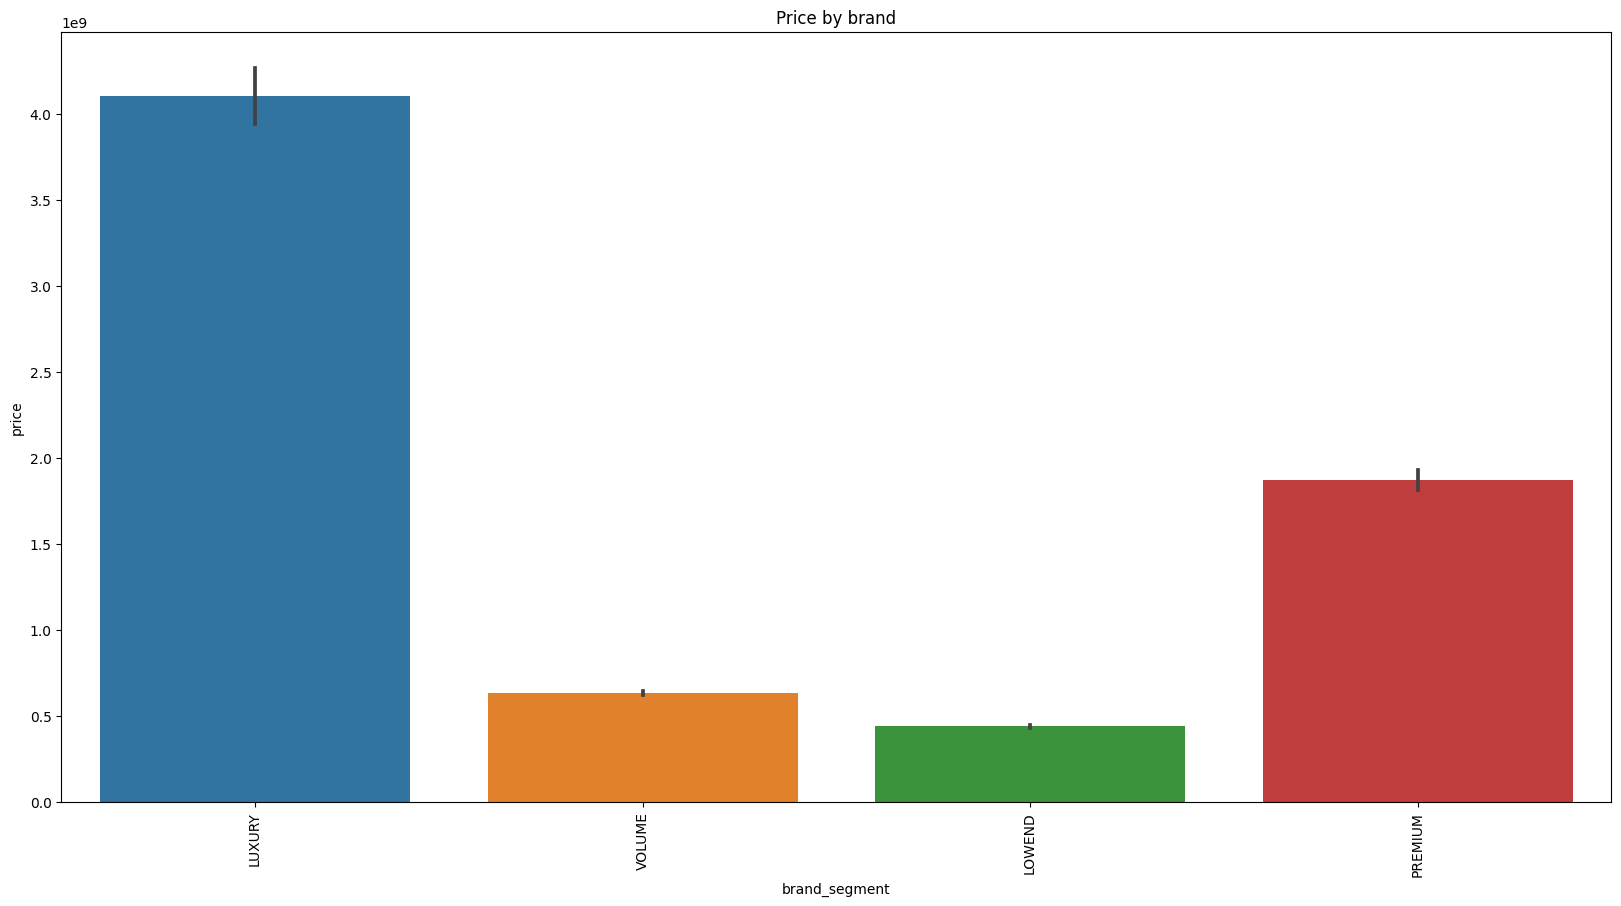

In [161]:
#vẽ price theo brand, series,year
plt.figure(figsize=(20, 10))
sns.barplot(x='brand_segment', y='price', data=df)
plt.title('Price by brand')
plt.xticks(rotation=90)
plt.show()

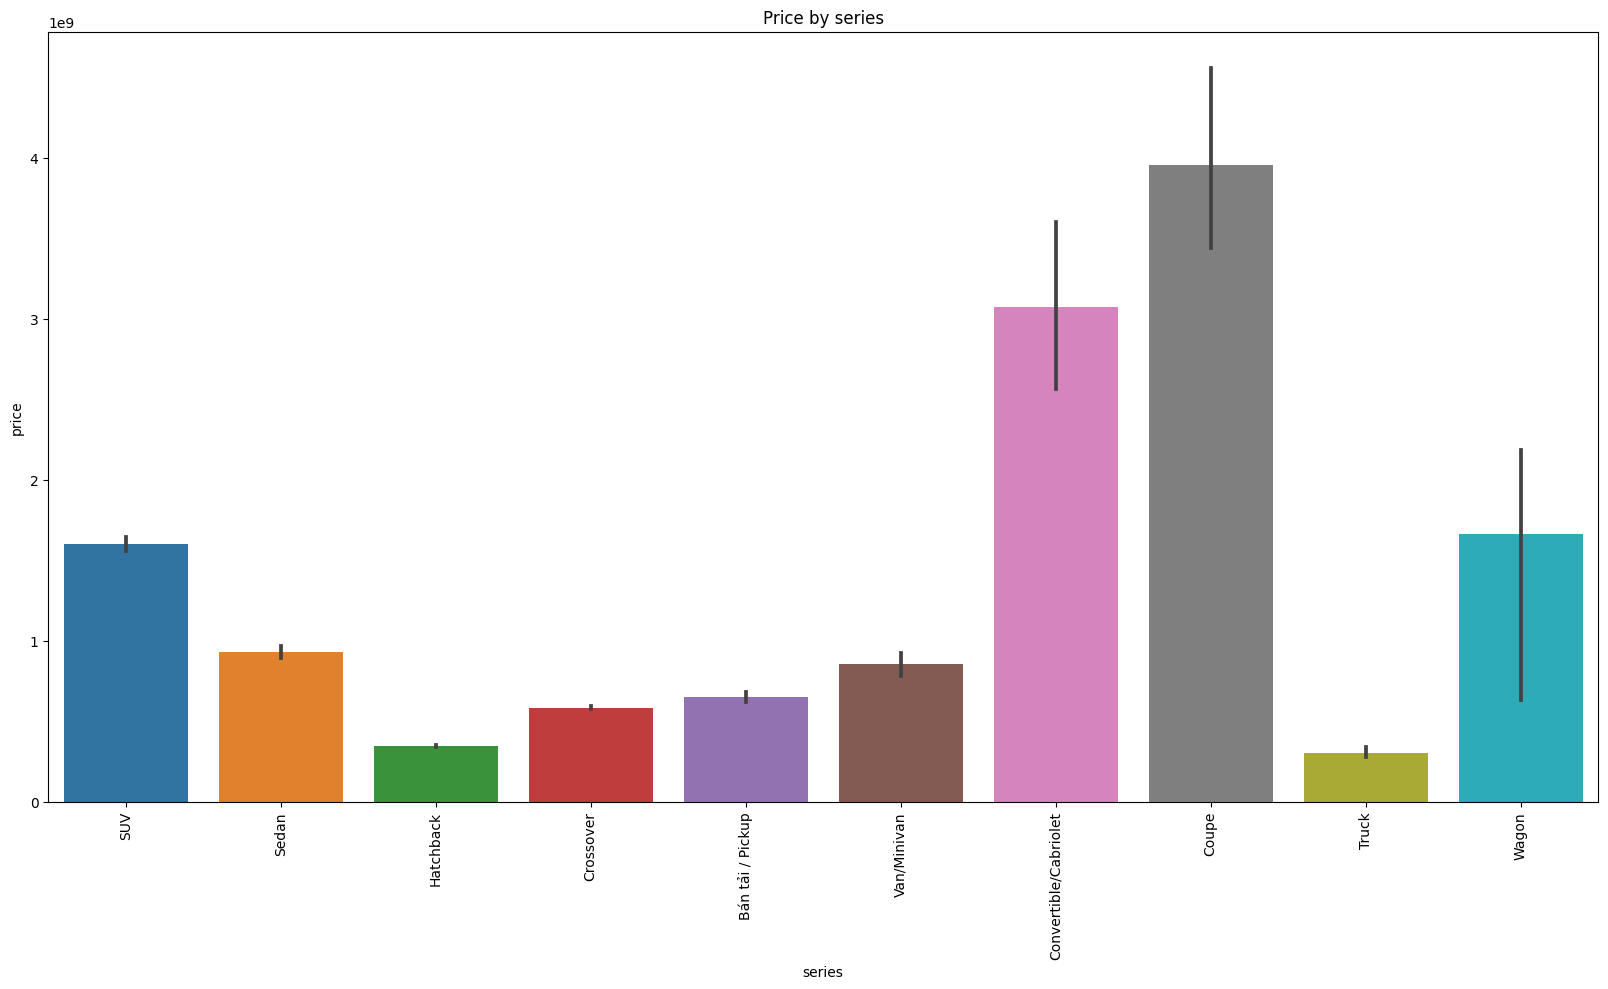

In [162]:
plt.figure(figsize=(20, 10))
sns.barplot(x='series', y='price', data=df)
plt.title('Price by series')
plt.xticks(rotation=90)
plt.show()

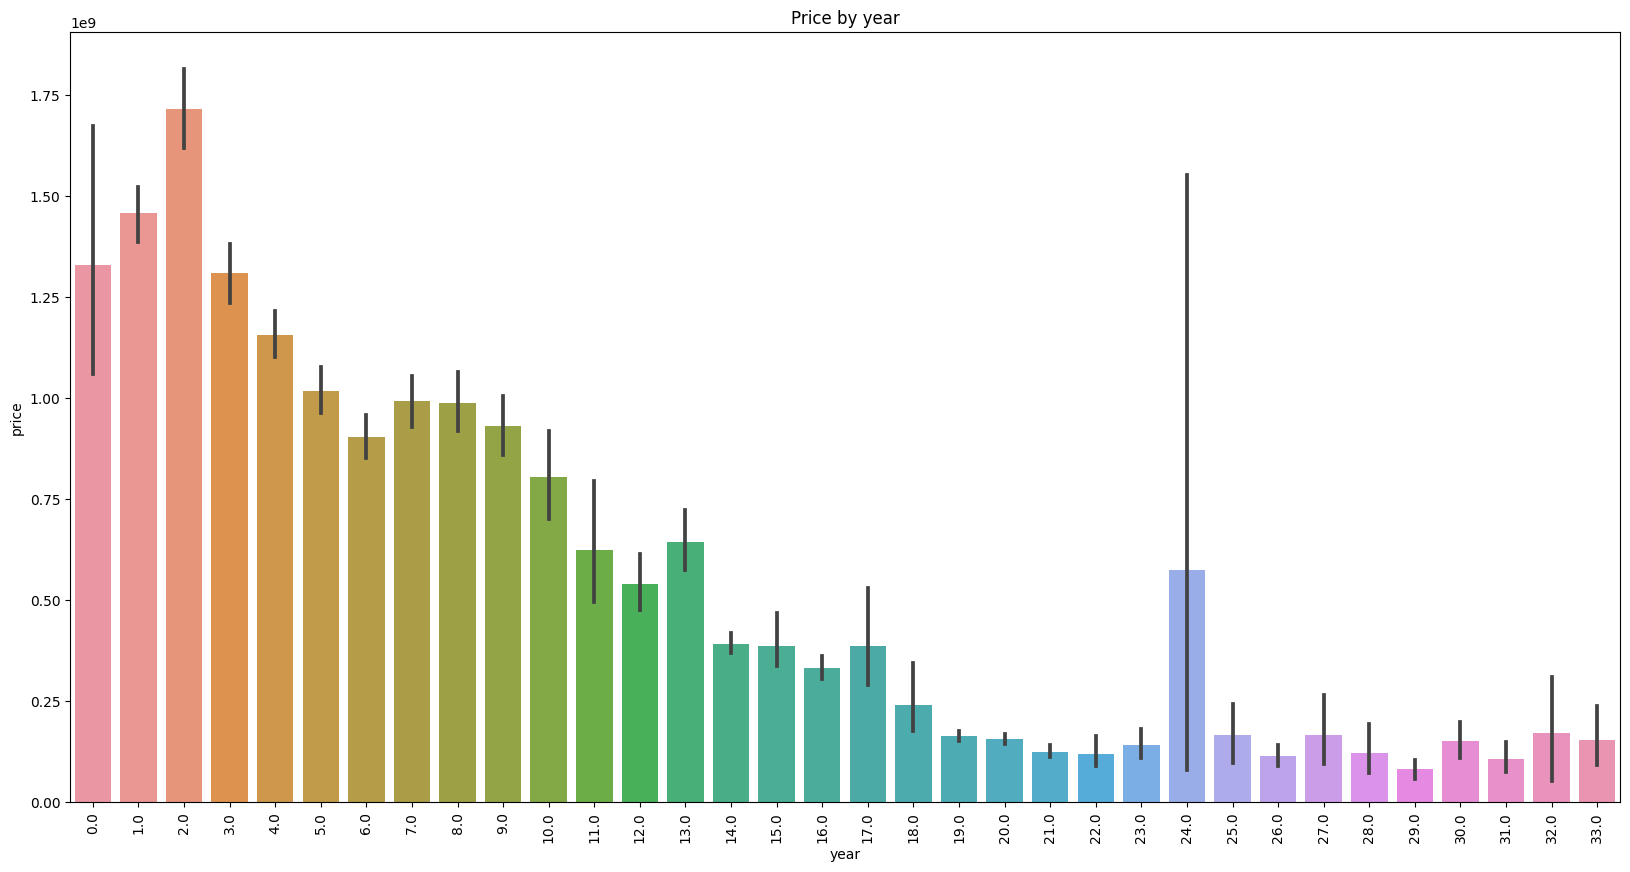

In [163]:
plt.figure(figsize=(20, 10))
#đổi năm sản xuất thành tuổi xe
df['year'] = 2023 - df['year']
sns.barplot(x='year', y='price', data=df)
plt.title('Price by year')
plt.xticks(rotation=90)
plt.show()

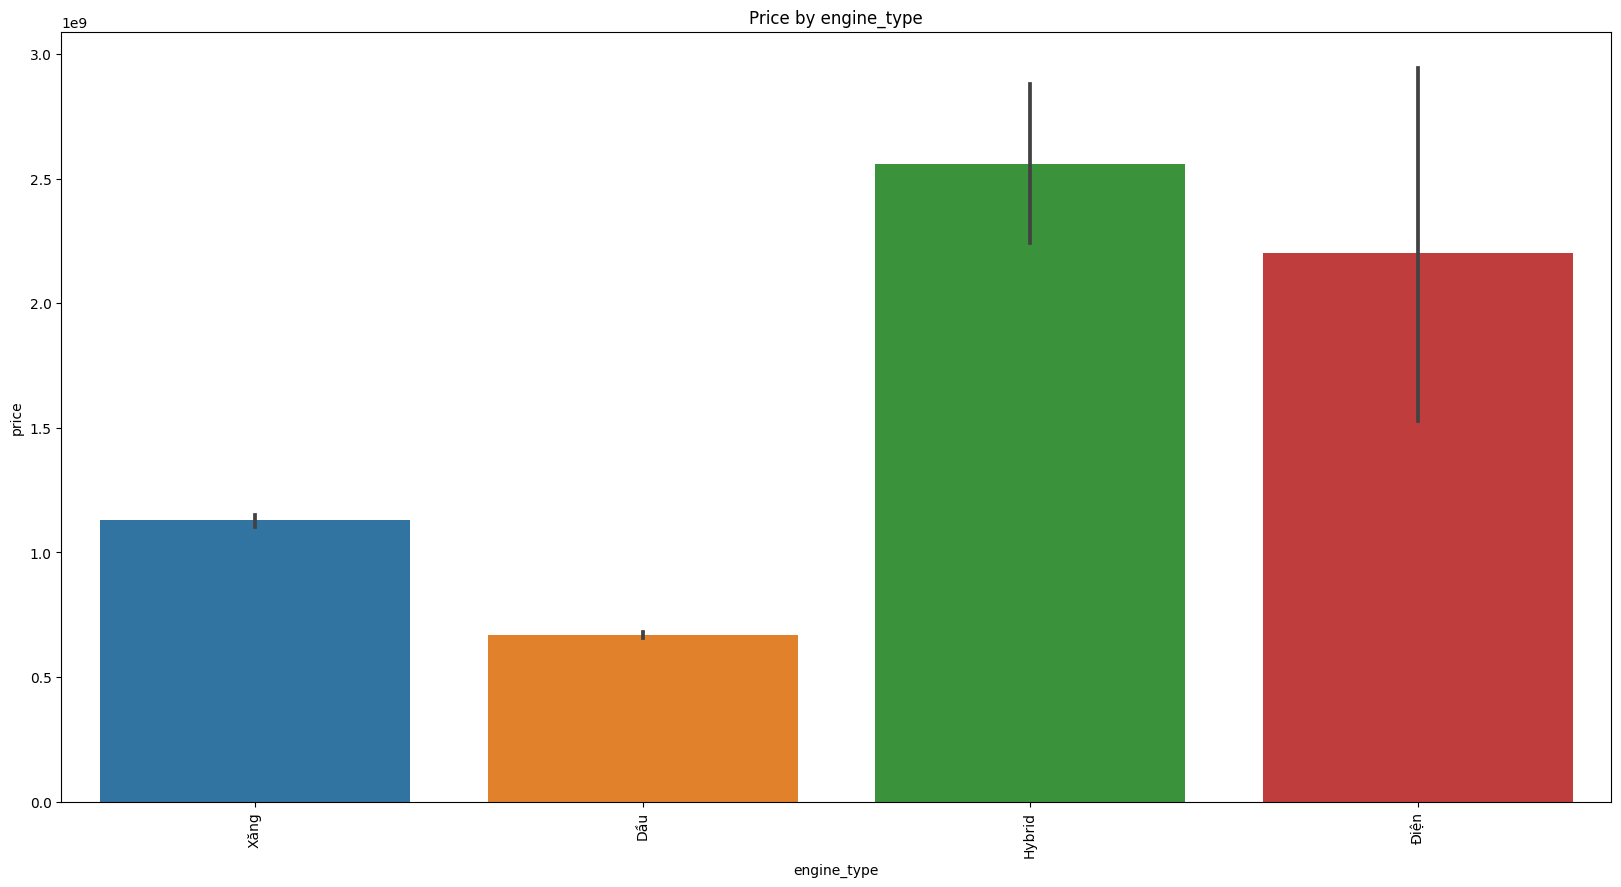

In [164]:
plt.figure(figsize=(20, 10))
sns.barplot(x='engine_type', y='price', data=df)
plt.title('Price by engine_type')
plt.xticks(rotation=90)
plt.show()


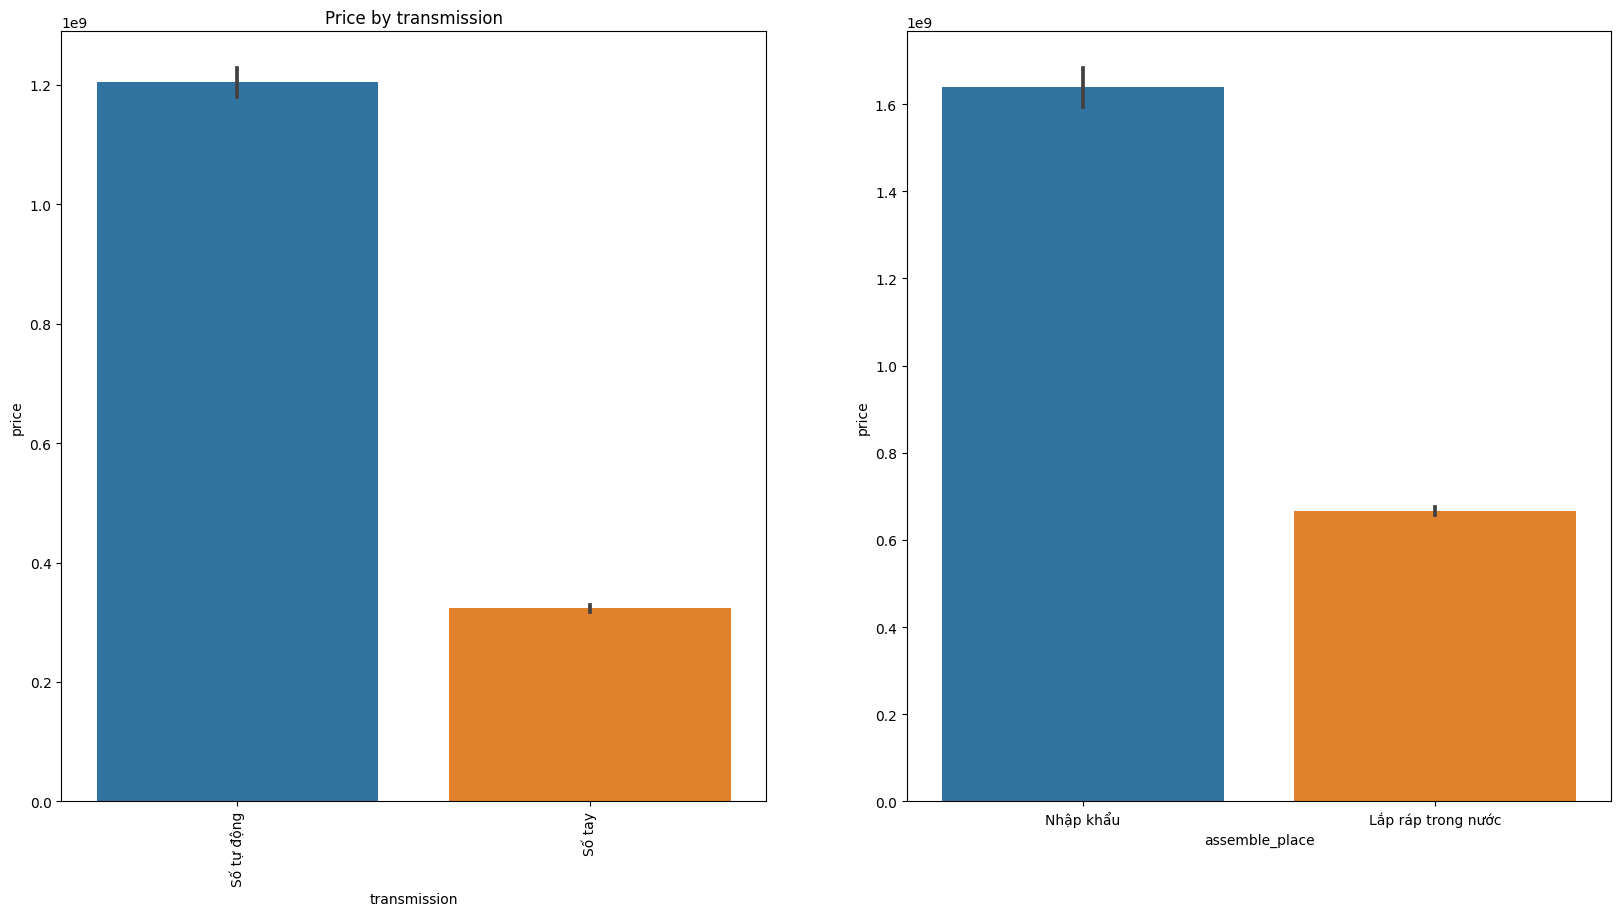

In [165]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.barplot(x='transmission', y='price', data=df)
plt.title('Price by transmission')
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
sns.barplot(x='assemble_place', y='price', data=df)
plt.show()

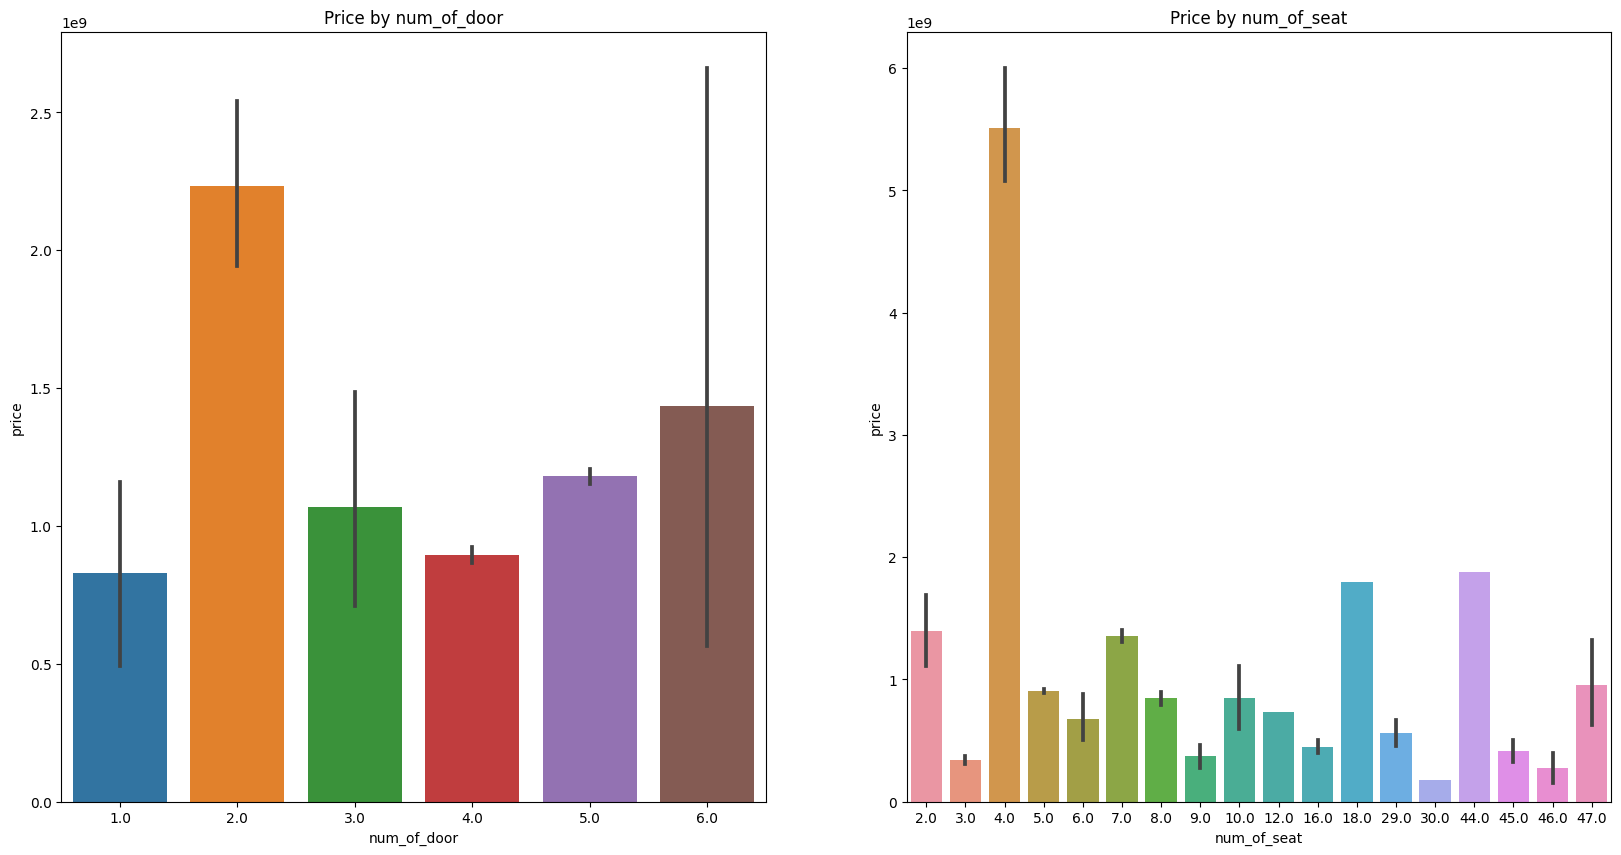

In [166]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.barplot(x='num_of_door', y='price', data=df)
plt.title('Price by num_of_door')
plt.subplot(1, 2, 2)
sns.barplot(x='num_of_seat', y='price', data=df)
plt.title('Price by num_of_seat')
plt.show()

# Tìm hiểu về mối liên hệ giữa các thuộc tính với nhau

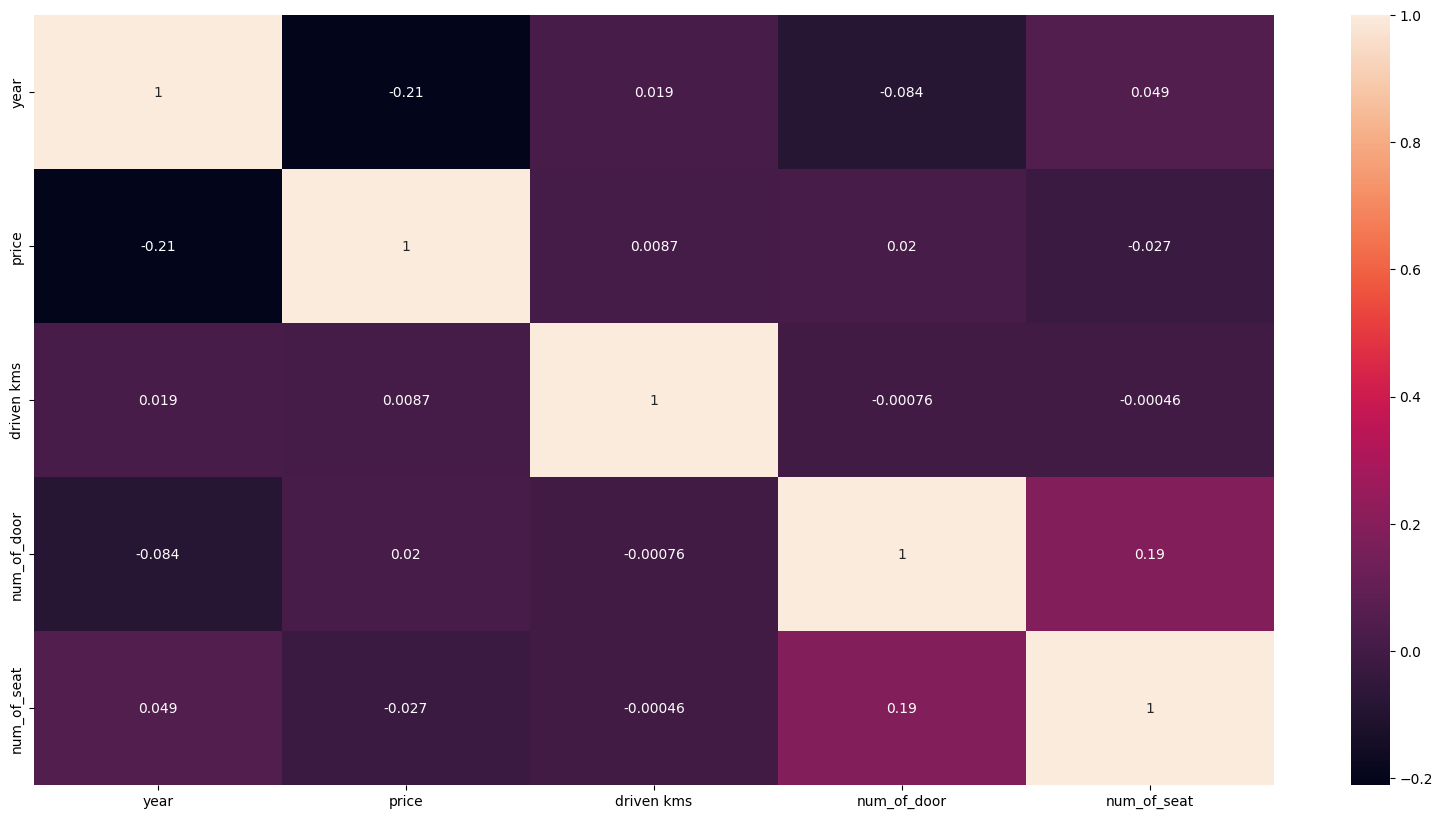

In [167]:
#vẽ biểu đồ nhiệt giữa price và các thuộc tính trừ model
plt.figure(figsize=(20, 10))
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()



# Mã hóa các cột dạng nhãn thành dạng số để có thể sử dụng cho mô hình học máy

Cột assemble_place chỉ có 2 giá trị là 'Lắp ráp trong nước' và 'Nhập khẩu', ta sẽ mã hóa thành 0 và 1

In [168]:
df['assemble_place'] = df['assemble_place'].map({'Lắp ráp trong nước': 0, 'Nhập khẩu': 1})

In [169]:
df['assemble_place'].value_counts()

assemble_place
0    14230
1    10264
Name: count, dtype: int64

Cột brand sẽ được mã hóa bằng phương pháp One-hot encoding

In [170]:
one_hot = OneHotEncoder()
one_hot.fit(df[['brand_segment']])
one_hot_brand = pd.get_dummies(df['brand_segment'], prefix='brand_segment')
df = pd.concat([df, one_hot_brand], axis=1)
df.drop('brand_segment', axis=1, inplace=True)
df.head()

,car_name,year,price,assemble_place,series,driven kms,num_of_door,num_of_seat,engine_type,transmission,url,model,brand_segment_LOWEND,brand_segment_LUXURY,brand_segment_PREMIUM,brand_segment_VOLUME
0,LandRover Range Rover HSE 3.0,8.0,2.700000e+09,1,SUV,65000.0,5.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-landrover-range_rover-h...,Range Rover HSE 3.0,False,True,False,False
1,Mitsubishi Outlander 2.0 CVT Premium,5.0,6.660000e+08,0,SUV,50000.0,5.0,7.0,Xăng,Số tự động,https://bonbanh.com/xe-mitsubishi-outlander-2....,Outlander 2.0 CVT Premium,False,False,False,True
2,Mazda 3 1.5L Luxury,4.0,4.900000e+08,0,Sedan,51000.0,4.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-mazda-3-1.5l-luxury-201...,3 1.5L Luxury,False,False,False,True
3,Mazda 2 1.5 AT,8.0,3.650000e+08,0,Sedan,38000.0,4.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-mazda-2-1.5-at-2015-491...,2 1.5 AT,False,False,False,True
4,Suzuki Swift GLX 1.2 AT,2.0,5.650000e+08,1,Hatchback,6000.0,5.0,5.0,Xăng,Số tự động,https://bonbanh.com/xe-suzuki-swift-glx-1.2-at...,Swift GLX 1.2 AT,True,False,False,False


Cột series sẽ được mã hóa bằng phương pháp One-hot encoding

In [171]:
one_hot = OneHotEncoder()
one_hot.fit(df[['series']])
one_hot_series = pd.get_dummies(df['series'], prefix='series')
df = pd.concat([df, one_hot_series], axis=1)

Cột engine_type sẽ được mã hóa bằng phương pháp One-hot encoding

In [172]:
df.head()

,car_name,year,price,assemble_place,series,driven kms,num_of_door,num_of_seat,engine_type,transmission,...,series_Bán tải / Pickup,series_Convertible/Cabriolet,series_Coupe,series_Crossover,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,series_Wagon
0,LandRover Range Rover HSE 3.0,8.0,2.700000e+09,1,SUV,65000.0,5.0,5.0,Xăng,Số tự động,...,False,False,False,False,False,True,False,False,False,False
1,Mitsubishi Outlander 2.0 CVT Premium,5.0,6.660000e+08,0,SUV,50000.0,5.0,7.0,Xăng,Số tự động,...,False,False,False,False,False,True,False,False,False,False
2,Mazda 3 1.5L Luxury,4.0,4.900000e+08,0,Sedan,51000.0,4.0,5.0,Xăng,Số tự động,...,False,False,False,False,False,False,True,False,False,False
3,Mazda 2 1.5 AT,8.0,3.650000e+08,0,Sedan,38000.0,4.0,5.0,Xăng,Số tự động,...,False,False,False,False,False,False,True,False,False,False
4,Suzuki Swift GLX 1.2 AT,2.0,5.650000e+08,1,Hatchback,6000.0,5.0,5.0,Xăng,Số tự động,...,False,False,False,False,True,False,False,False,False,False


In [173]:
one_hot = OneHotEncoder()
one_hot.fit(df[['engine_type']])
one_hot_engine_type = pd.get_dummies(df['engine_type'], prefix='engine_type')
df = pd.concat([df, one_hot_engine_type], axis=1)

Cột transmission chỉ có hai giá trị nên sẽ được mã hóa thành 0 và 1

In [174]:
df['transmission'] = df['transmission'].map({'Số tay': 0, 'Số tự động': 1})

In [175]:
df.head()

,car_name,year,price,assemble_place,series,driven kms,num_of_door,num_of_seat,engine_type,transmission,...,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,series_Wagon,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,LandRover Range Rover HSE 3.0,8.0,2.700000e+09,1,SUV,65000.0,5.0,5.0,Xăng,1,...,False,True,False,False,False,False,False,False,True,False
1,Mitsubishi Outlander 2.0 CVT Premium,5.0,6.660000e+08,0,SUV,50000.0,5.0,7.0,Xăng,1,...,False,True,False,False,False,False,False,False,True,False
2,Mazda 3 1.5L Luxury,4.0,4.900000e+08,0,Sedan,51000.0,4.0,5.0,Xăng,1,...,False,False,True,False,False,False,False,False,True,False
3,Mazda 2 1.5 AT,8.0,3.650000e+08,0,Sedan,38000.0,4.0,5.0,Xăng,1,...,False,False,True,False,False,False,False,False,True,False
4,Suzuki Swift GLX 1.2 AT,2.0,5.650000e+08,1,Hatchback,6000.0,5.0,5.0,Xăng,1,...,True,False,False,False,False,False,False,False,True,False


In [176]:
save_df = copy.deepcopy(df)

In [177]:
save_df.head()

,car_name,year,price,assemble_place,series,driven kms,num_of_door,num_of_seat,engine_type,transmission,...,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,series_Wagon,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,LandRover Range Rover HSE 3.0,8.0,2.700000e+09,1,SUV,65000.0,5.0,5.0,Xăng,1,...,False,True,False,False,False,False,False,False,True,False
1,Mitsubishi Outlander 2.0 CVT Premium,5.0,6.660000e+08,0,SUV,50000.0,5.0,7.0,Xăng,1,...,False,True,False,False,False,False,False,False,True,False
2,Mazda 3 1.5L Luxury,4.0,4.900000e+08,0,Sedan,51000.0,4.0,5.0,Xăng,1,...,False,False,True,False,False,False,False,False,True,False
3,Mazda 2 1.5 AT,8.0,3.650000e+08,0,Sedan,38000.0,4.0,5.0,Xăng,1,...,False,False,True,False,False,False,False,False,True,False
4,Suzuki Swift GLX 1.2 AT,2.0,5.650000e+08,1,Hatchback,6000.0,5.0,5.0,Xăng,1,...,True,False,False,False,False,False,False,False,True,False


# Sử dụng Standardization để chuẩn hóa dữ liệu

In [178]:
scaler = StandardScaler()
df=save_df.copy()
#fit year và driven kms
scaler.fit(df[['driven kms','num_of_seat']])
df[['driven kms','num_of_seat']] = scaler.transform(df[['driven kms','num_of_seat']])

In [179]:
df.head()

,car_name,year,price,assemble_place,series,driven kms,num_of_door,num_of_seat,engine_type,transmission,...,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,series_Wagon,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,LandRover Range Rover HSE 3.0,8.0,2.700000e+09,1,SUV,-0.014315,5.0,-0.316591,Xăng,1,...,False,True,False,False,False,False,False,False,True,False
1,Mitsubishi Outlander 2.0 CVT Premium,5.0,6.660000e+08,0,SUV,-0.014782,5.0,0.863261,Xăng,1,...,False,True,False,False,False,False,False,False,True,False
2,Mazda 3 1.5L Luxury,4.0,4.900000e+08,0,Sedan,-0.014751,4.0,-0.316591,Xăng,1,...,False,False,True,False,False,False,False,False,True,False
3,Mazda 2 1.5 AT,8.0,3.650000e+08,0,Sedan,-0.015156,4.0,-0.316591,Xăng,1,...,False,False,True,False,False,False,False,False,True,False
4,Suzuki Swift GLX 1.2 AT,2.0,5.650000e+08,1,Hatchback,-0.016152,5.0,-0.316591,Xăng,1,...,True,False,False,False,False,False,False,False,True,False


# Sử dụng hồi quy tuyến tính để dự đoán giá xe

In [180]:
df.head()

,car_name,year,price,assemble_place,series,driven kms,num_of_door,num_of_seat,engine_type,transmission,...,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,series_Wagon,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,LandRover Range Rover HSE 3.0,8.0,2.700000e+09,1,SUV,-0.014315,5.0,-0.316591,Xăng,1,...,False,True,False,False,False,False,False,False,True,False
1,Mitsubishi Outlander 2.0 CVT Premium,5.0,6.660000e+08,0,SUV,-0.014782,5.0,0.863261,Xăng,1,...,False,True,False,False,False,False,False,False,True,False
2,Mazda 3 1.5L Luxury,4.0,4.900000e+08,0,Sedan,-0.014751,4.0,-0.316591,Xăng,1,...,False,False,True,False,False,False,False,False,True,False
3,Mazda 2 1.5 AT,8.0,3.650000e+08,0,Sedan,-0.015156,4.0,-0.316591,Xăng,1,...,False,False,True,False,False,False,False,False,True,False
4,Suzuki Swift GLX 1.2 AT,2.0,5.650000e+08,1,Hatchback,-0.016152,5.0,-0.316591,Xăng,1,...,True,False,False,False,False,False,False,False,True,False


In [181]:
print(df.columns)

Index(['car_name', 'year', 'price', 'assemble_place', 'series', 'driven kms',
       'num_of_door', 'num_of_seat', 'engine_type', 'transmission', 'url',
       'model', 'brand_segment_LOWEND', 'brand_segment_LUXURY',
       'brand_segment_PREMIUM', 'brand_segment_VOLUME',
       'series_Bán tải / Pickup', 'series_Convertible/Cabriolet',
       'series_Coupe', 'series_Crossover', 'series_Hatchback', 'series_SUV',
       'series_Sedan', 'series_Truck', 'series_Van/Minivan', 'series_Wagon',
       'engine_type_Dầu', 'engine_type_Hybrid', 'engine_type_Xăng',
       'engine_type_Điện'],
      dtype='object')


In [182]:
df.drop(['model', 'series', 'engine_type','car_name','url'], axis=1, inplace=True)

In [183]:
df.head()

,year,price,assemble_place,driven kms,num_of_door,num_of_seat,transmission,brand_segment_LOWEND,brand_segment_LUXURY,brand_segment_PREMIUM,...,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,series_Wagon,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,8.0,2.700000e+09,1,-0.014315,5.0,-0.316591,1,False,True,False,...,False,True,False,False,False,False,False,False,True,False
1,5.0,6.660000e+08,0,-0.014782,5.0,0.863261,1,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,4.0,4.900000e+08,0,-0.014751,4.0,-0.316591,1,False,False,False,...,False,False,True,False,False,False,False,False,True,False
3,8.0,3.650000e+08,0,-0.015156,4.0,-0.316591,1,False,False,False,...,False,False,True,False,False,False,False,False,True,False
4,2.0,5.650000e+08,1,-0.016152,5.0,-0.316591,1,True,False,False,...,True,False,False,False,False,False,False,False,True,False


In [184]:
df.dropna(inplace=True)

In [185]:
model = LinearRegression()
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))


0.4706330893125257


In [186]:
df.head()

,year,price,assemble_place,driven kms,num_of_door,num_of_seat,transmission,brand_segment_LOWEND,brand_segment_LUXURY,brand_segment_PREMIUM,...,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,series_Wagon,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,8.0,2.700000e+09,1,-0.014315,5.0,-0.316591,1,False,True,False,...,False,True,False,False,False,False,False,False,True,False
1,5.0,6.660000e+08,0,-0.014782,5.0,0.863261,1,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,4.0,4.900000e+08,0,-0.014751,4.0,-0.316591,1,False,False,False,...,False,False,True,False,False,False,False,False,True,False
3,8.0,3.650000e+08,0,-0.015156,4.0,-0.316591,1,False,False,False,...,False,False,True,False,False,False,False,False,True,False
4,2.0,5.650000e+08,1,-0.016152,5.0,-0.316591,1,True,False,False,...,True,False,False,False,False,False,False,False,True,False


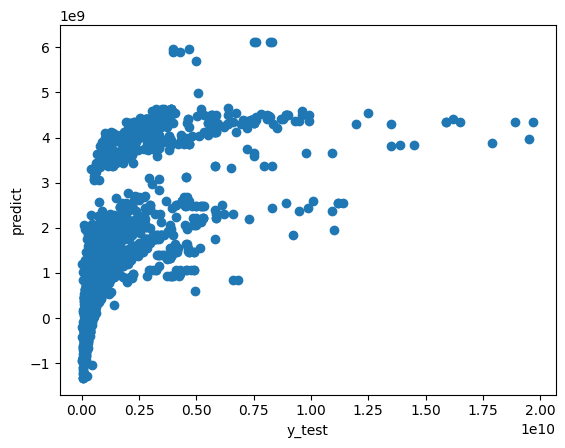

In [187]:
predict = model.predict(X_test)
plt.scatter(y_test, predict)
plt.xlabel('y_test')
plt.ylabel('predict')
plt.show()

/tmp/ipykernel_1494/592410835.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test-predict),bins=50);


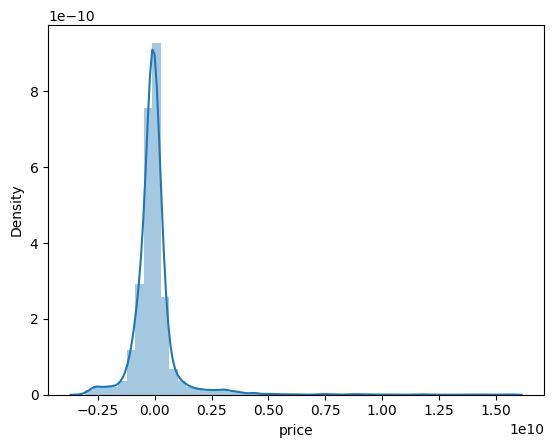

In [188]:
sns.distplot((y_test-predict),bins=50);


In [189]:


print('MAE:', metrics.mean_absolute_error(y_test, predict))
print('MSE:', metrics.mean_squared_error(y_test, predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predict)))


MAE: 534861673.5401181
MSE: 1.235952122351531e+18
RMSE: 1111733836.1098537


In [190]:
# thử sử dụng random forest

In [191]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [192]:
from sklearn.model_selection import KFold, RandomizedSearchCV

"""
+ Search over space of hyperparameters to find acceptable ones
+ Two search methods implemented by scikit-learn: GridSearch and RandomSearch
+ RandomSearch is faster in case we search over large space (too many combinations of hyperparameters)
"""

rf_hyperparams = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [None, 10, 50, 90, 110],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_randomized_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = rf_hyperparams,
    n_iter = 10,
    cv=KFold(n_splits=10, shuffle=True, random_state=42),
    verbose=2,
    random_state=42,
    n_jobs = -1
)



In [193]:
rf_randomized_search.fit(X_train, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.2s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.4s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.3s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.9s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, max_depth=110, m

/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.1s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.1s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  20.6s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  20.8s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  20.8s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  20.7s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  20.9s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  21.0s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  20.6s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  20.7s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   6.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   6.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   6.2s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  20.8s
[CV] END bootstrap=True, max_depth=No

/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   6.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   5.9s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  12.4s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  12.9s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  12.6s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  12.7s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  12.7s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  12.9s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  12.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  12.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  12.8s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.6s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   3.5s
[CV] END bootstrap=False, max_dept

/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   6.2s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   6.2s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   5.9s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.6s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.5s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.4s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.7s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.6s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.6s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.6s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.8s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.2s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.2s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.5s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  15.6s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.3s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.3s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.5s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.3s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.4s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.7s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.3s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   9.2s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  23.0s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  23.0s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  23.0s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  23.1s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  23.2s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  23.2s


/home/codespace/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  23.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  23.1s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  16.3s
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=  15.9s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 50, 90, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 400, 500]},
                   random_state=42, verbose=2)

In [194]:
rf_randomized_search.score(X_test, y_test)

0.7245717074285472

In [195]:
print('MAE:', metrics.mean_absolute_error(y_test, rf_randomized_search.predict(X_test)))
print('MSE:', metrics.mean_squared_error(y_test, rf_randomized_search.predict(X_test)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf_randomized_search.predict(X_test))))


MAE: 279699604.88670266
MSE: 6.43062828232419e+17
RMSE: 801911982.8462591


In [196]:
# predict thử cho xe có url:https://bonbanh.com/xe-toyota-prado-vx-2.7l-2022-4925201 trong tập data set
car =save_df[save_df['url'] == 'https://bonbanh.com/xe-toyota-corolla_altis-1.8e-at-2021-5009589']
car.drop(['model', 'series', 'engine_type','car_name','url','price'], axis=1, inplace=True)
print('price of car is: ',rf_randomized_search.predict(car)[0])


price of car is:  625196315.9065259


/tmp/ipykernel_1494/1173370074.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car.drop(['model', 'series', 'engine_type','car_name','url','price'], axis=1, inplace=True)


In [197]:
from sklearn.linear_model import Ridge
rg = Ridge(alpha=1.0)
rg.fit(X_train, y_train)
rg.score(X_test, y_test)


0.47063294280369183

In [198]:
#Support Vector Regression

In [199]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

-0.09719368822129093

In [200]:
df.head()

,year,price,assemble_place,driven kms,num_of_door,num_of_seat,transmission,brand_segment_LOWEND,brand_segment_LUXURY,brand_segment_PREMIUM,...,series_Hatchback,series_SUV,series_Sedan,series_Truck,series_Van/Minivan,series_Wagon,engine_type_Dầu,engine_type_Hybrid,engine_type_Xăng,engine_type_Điện
0,8.0,2.700000e+09,1,-0.014315,5.0,-0.316591,1,False,True,False,...,False,True,False,False,False,False,False,False,True,False
1,5.0,6.660000e+08,0,-0.014782,5.0,0.863261,1,False,False,False,...,False,True,False,False,False,False,False,False,True,False
2,4.0,4.900000e+08,0,-0.014751,4.0,-0.316591,1,False,False,False,...,False,False,True,False,False,False,False,False,True,False
3,8.0,3.650000e+08,0,-0.015156,4.0,-0.316591,1,False,False,False,...,False,False,True,False,False,False,False,False,True,False
4,2.0,5.650000e+08,1,-0.016152,5.0,-0.316591,1,True,False,False,...,True,False,False,False,False,False,False,False,True,False


In [201]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Định nghĩa lưới các tham số
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

mlp = MLPRegressor(max_iter=100)

clf = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error')

clf.fit(X_train, y_train)

print(f'Best parameters: {clf.best_params_}')


/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/codespace/.local/lib/python3.1

In [ ]:
clf.score(X_test, y_test)

-2.340090858279284e+18